In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


#Import Data

In [2]:
pod_number = 'F5'

In [4]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F5_all.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [5]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [258]:
df_scaled, features = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

13927

###Declare whether you'd like to use holdout dates from a pervious run.

In [7]:
prev_holdout = "true"
chunks = ['8-24 AM', '8-27 PM', '8-28 PM']

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [8]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

In [9]:
df_hold['chunk'].unique()

array(['8-24 AM', '8-27 PM', '8-28 PM'], dtype=object)

###Declare a cutoff value for 'high' ozone.

In [171]:
cutoff_value = 50

####Plot the training ozone

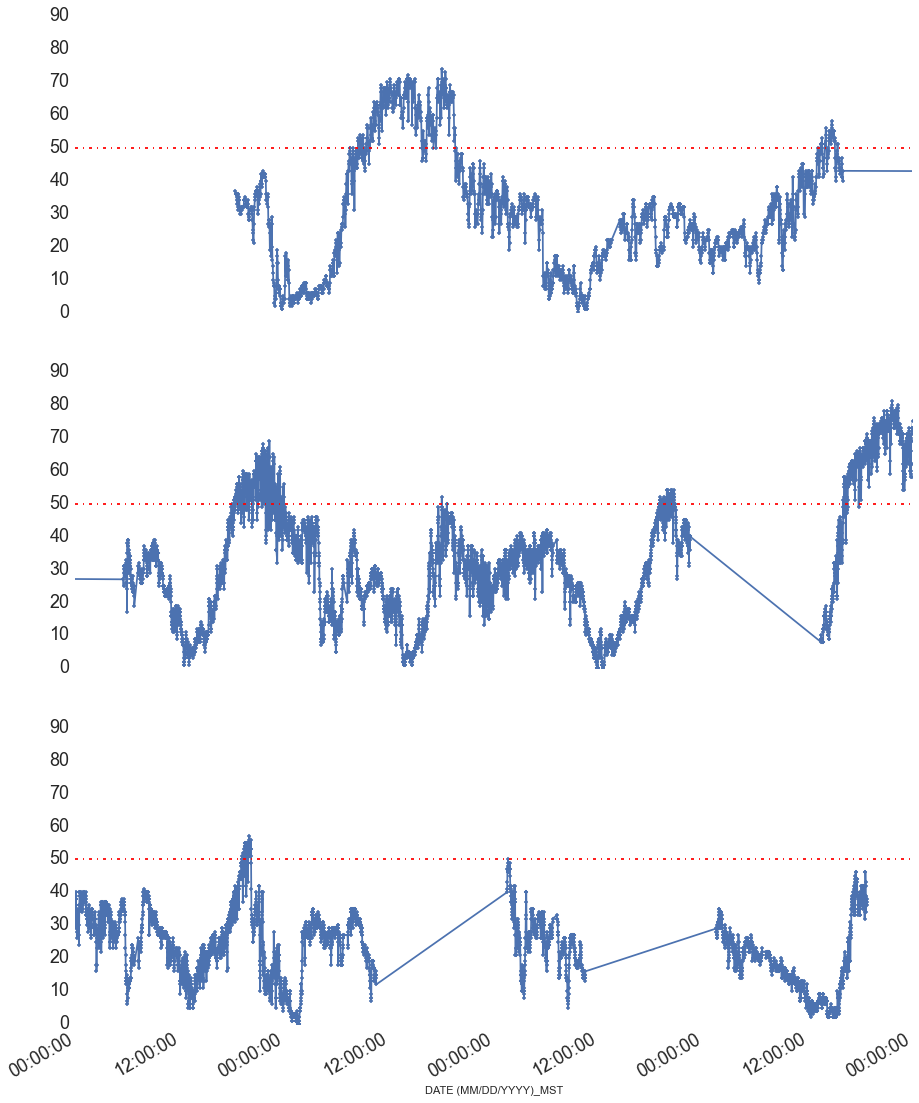

In [172]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

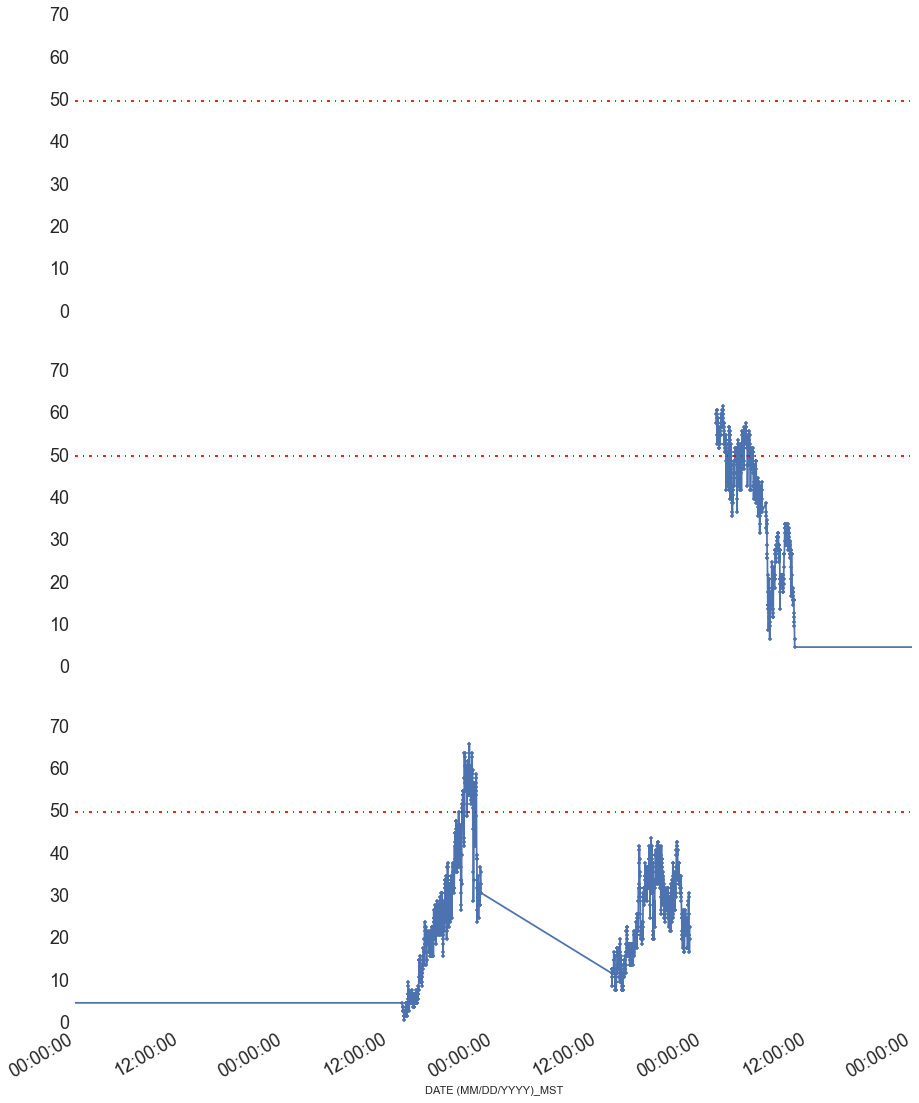

In [173]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

###Declare a multiplication factor for the MSE part of the custom score function.

In [174]:
cust_mse_fact = 1

#Linear Regression with Base Features

In [175]:
base_features = [pod_ozone,'Temp','Rh']

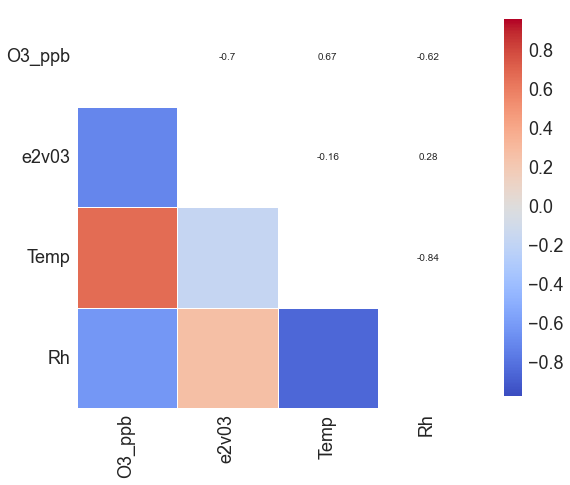

In [176]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [177]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.2
Cross-Validation RMSE: 8.0 , High-Value CV RMSE: 10.0 , CV High Diff. in Mean (>50): -9.9
Holdout RMSE: 10.0 , High-Value Holdout RMSE: 15.0 , Holdout High Diff. in Mean.: -14.3


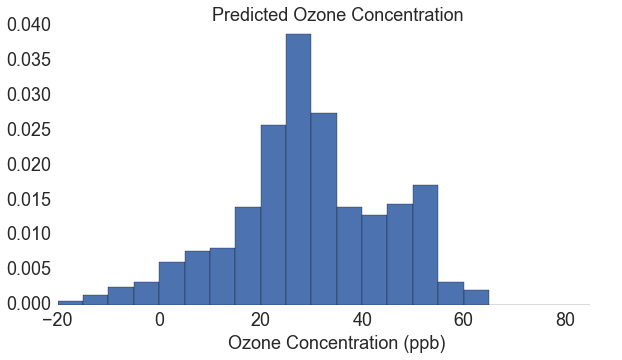

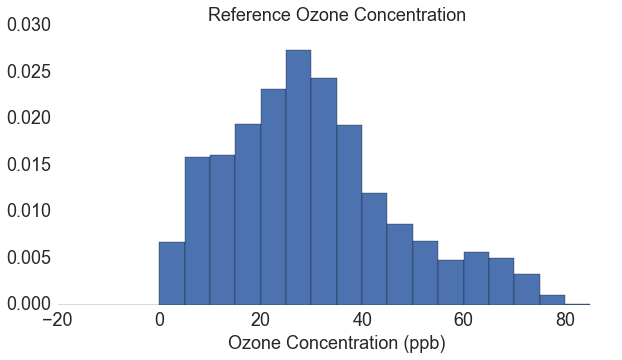

In [178]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

####Plot the learning curve for a linear regression with the base features.

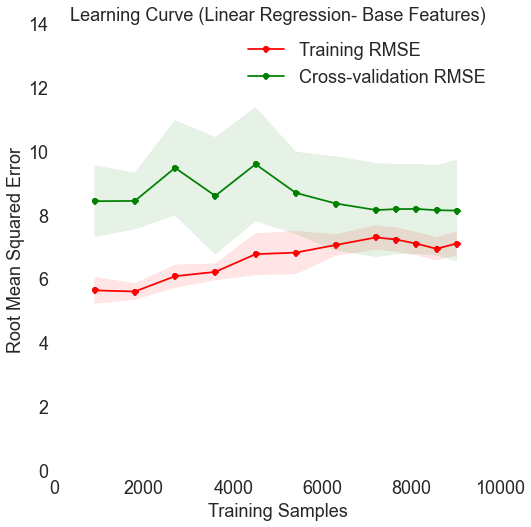

In [179]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,14), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

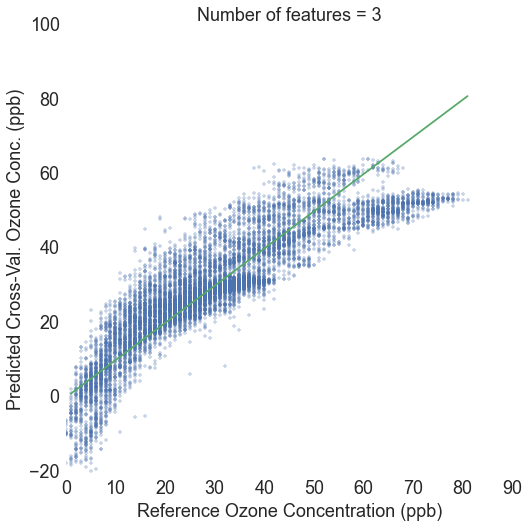

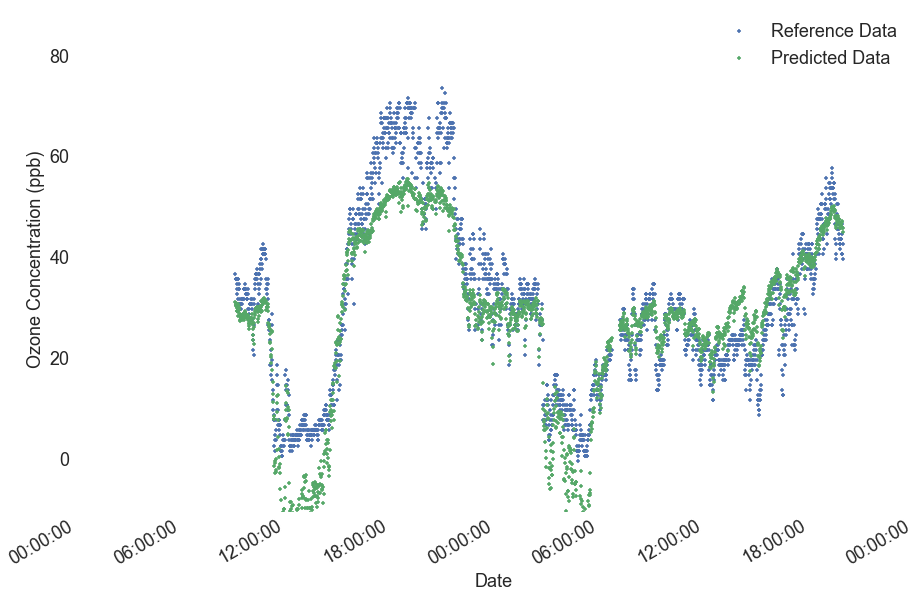

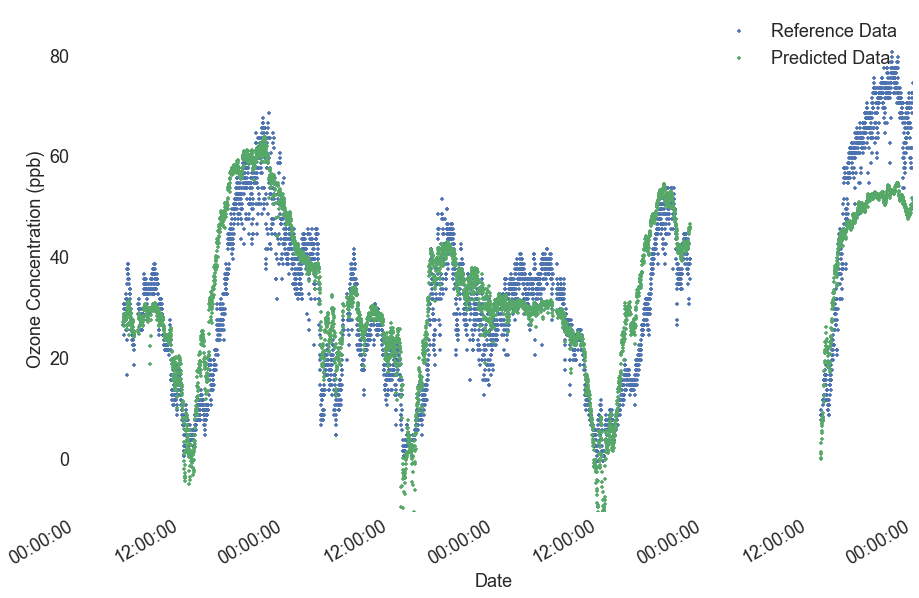

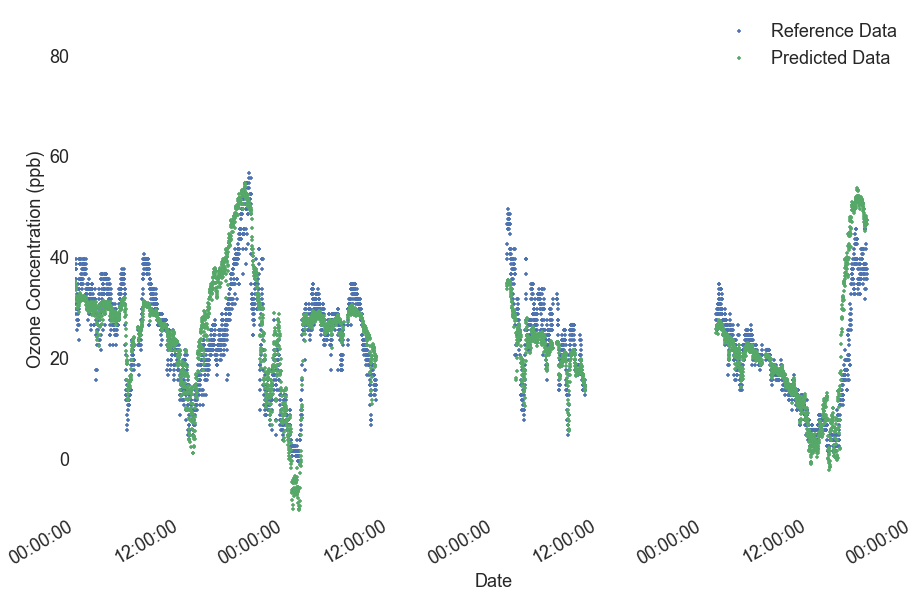

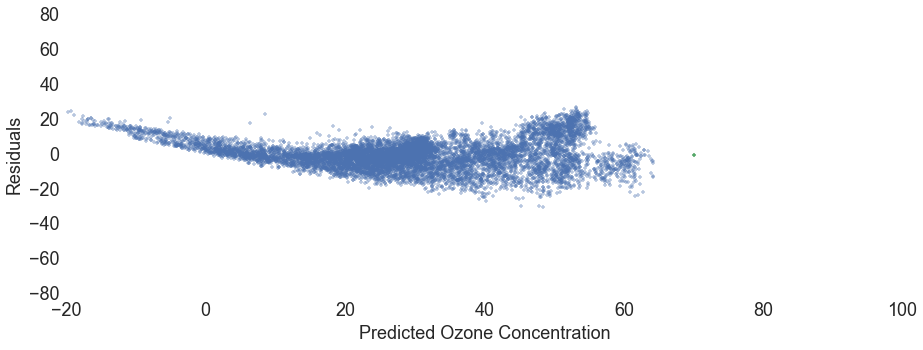

In [180]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#Linear Regression with All Features.

In [181]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 2.5
Cross-Validation RMSE: 7.0 , High-Value CV RMSE: 10.0 , CV High Diff. in Mean (>50): -6.0
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 15.0 , Holdout High Diff. in Mean.: 10.9


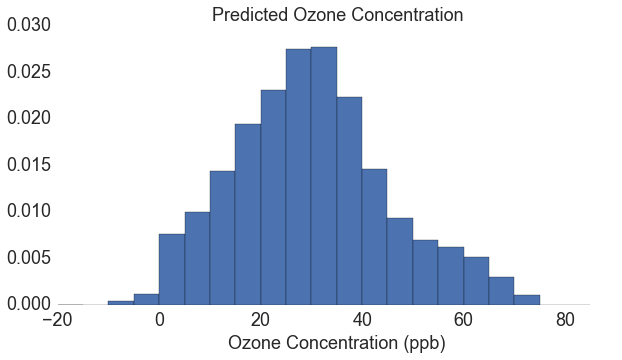

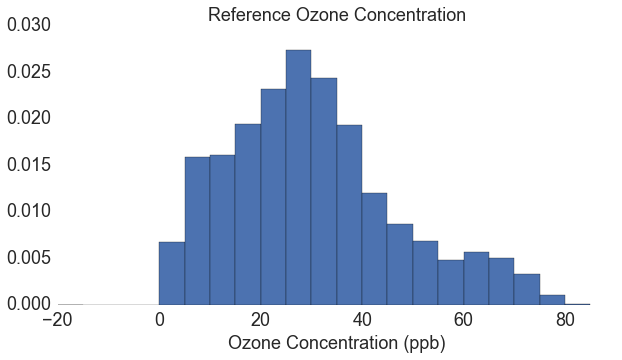

In [182]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

####Plot a learning curve with all features.

KeyboardInterrupt: 

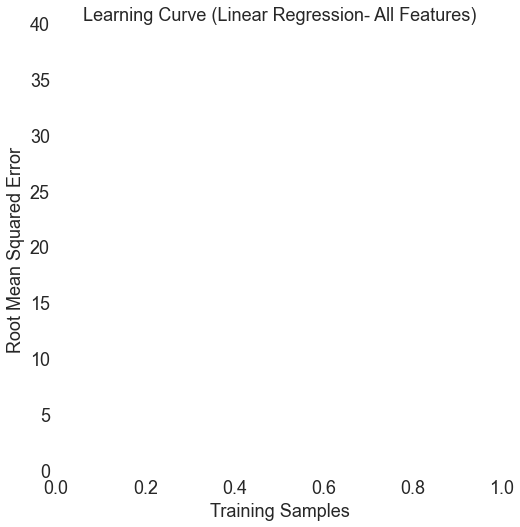

In [111]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,40), 5, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 1.0]))

###Plot the residuals and comparison curves.

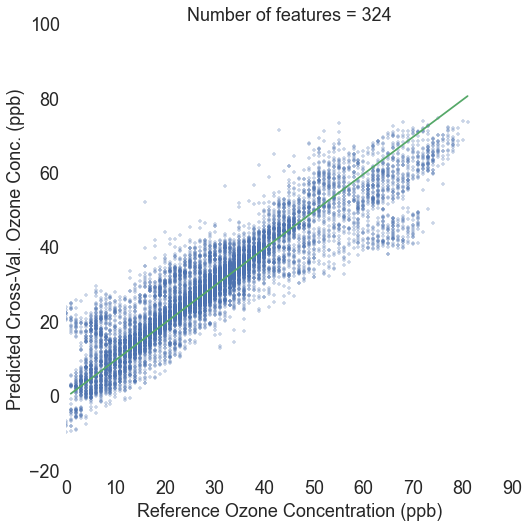

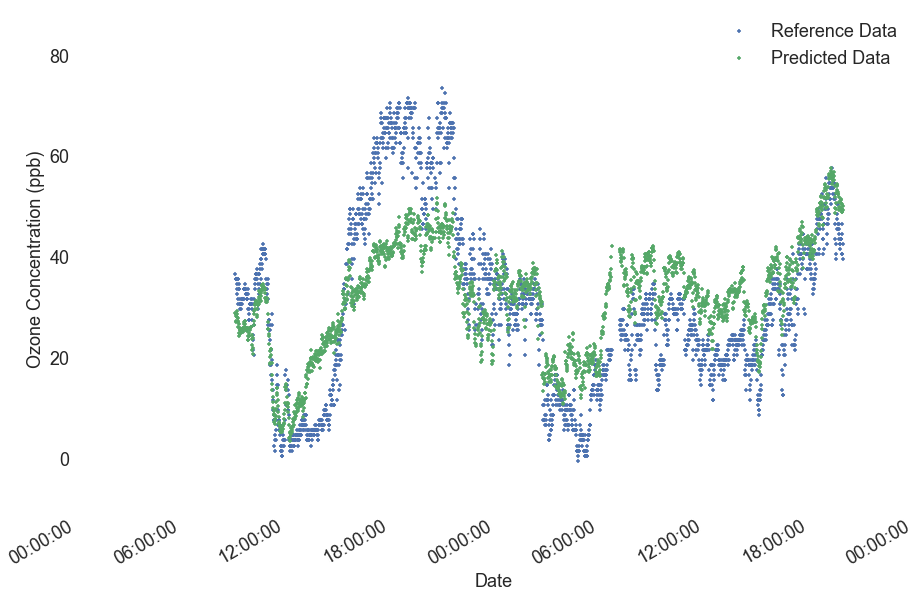

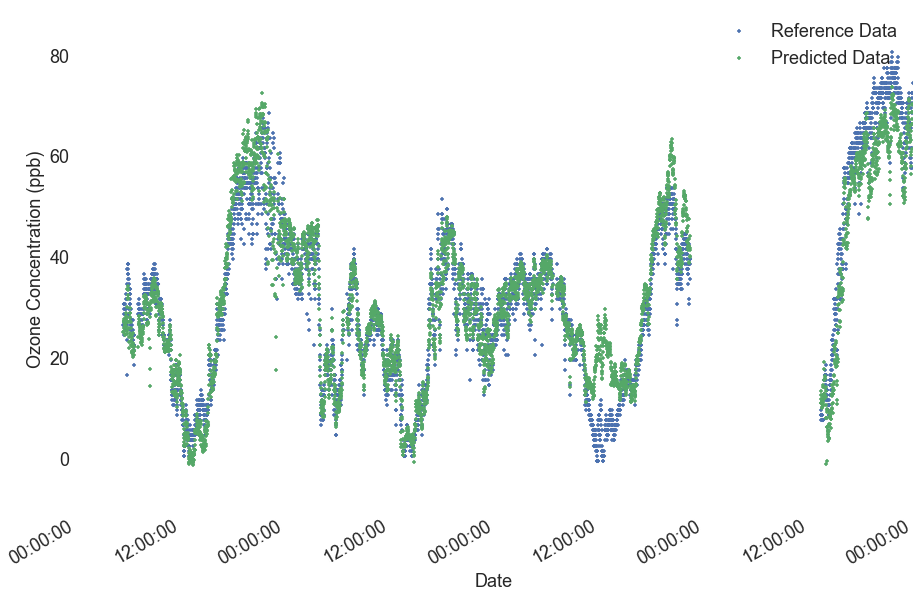

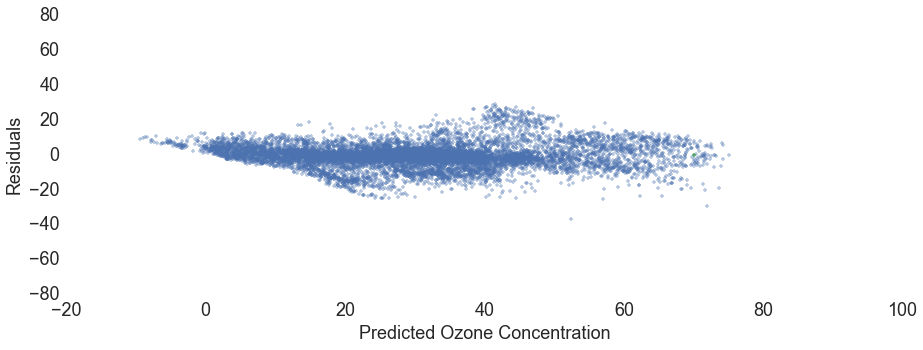

In [183]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [184]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 35, cust_mse_fact, cutoff_value)

Next best Feature:  ln_o3_rh_int_lead_5 , Score:  14.3 RMSE:  2.0 #: 1
Next best Feature:  days from start , Score:  10.5 RMSE:  2.0 #: 2
Next best Feature:  ln_rh_slope_lead_90 , Score:  8.4 RMSE:  2.2 #: 3
Next best Feature:  temp_cu , Score:  7.8 RMSE:  2.4 #: 4
Next best Feature:  Rh_int_lag_75 , Score:  6.9 RMSE:  1.8 #: 5
Next best Feature:  o3_temp_slope_lag_90 , Score:  6.6 RMSE:  2.0 #: 6
Next best Feature:  ln_temp_rh_slope_lead_60 , Score:  6.4 RMSE:  3.7 #: 7
Next best Feature:  e2v03_slope_lag_90 , Score:  6.2 RMSE:  4.3 #: 8
Next best Feature:  ln_o3_rh_int_lag_5 , Score:  6.1 RMSE:  2.6 #: 9
Next best Feature:  ln_o3_temp_rh_slope_lag_90 , Score:  6.0 RMSE:  4.0 #: 10
Next best Feature:  ln_o3_rh_slope_lag_90 , Score:  6.0 RMSE:  4.0 #: 11
Next best Feature:  e2v03_slope_lead_5 , Score:  5.9 RMSE:  4.5 #: 12
Next best Feature:  ln_03_mult_ln_rh , Score:  5.9 RMSE:  2.5 #: 13
Next best Feature:  ln_03_mult_ln_temp , Score:  5.8 RMSE:  1.8 #: 14
Next best Feature:  o3_temp

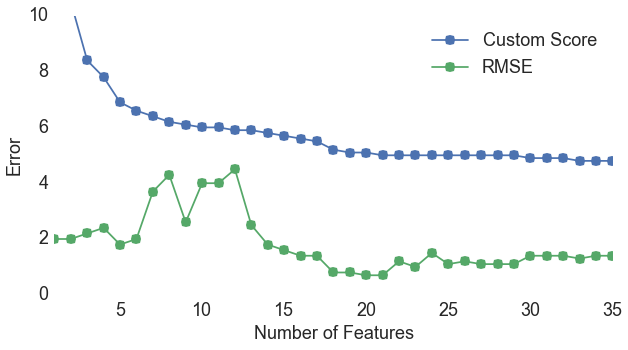

In [185]:
plot_error_vs_features(score, RMSE, [0,10], [1,35])

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

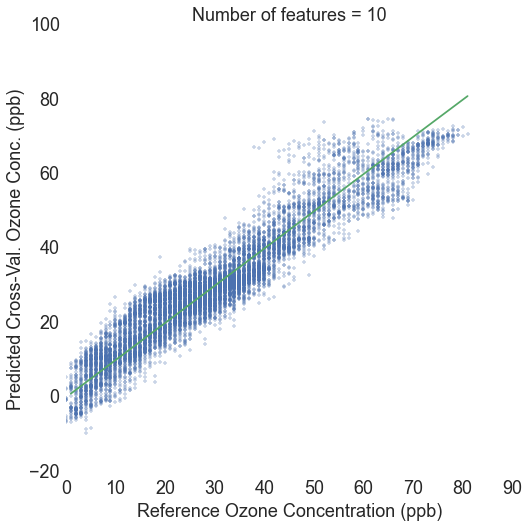

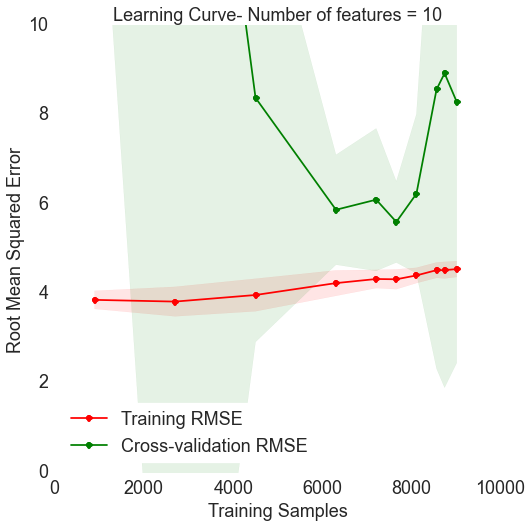

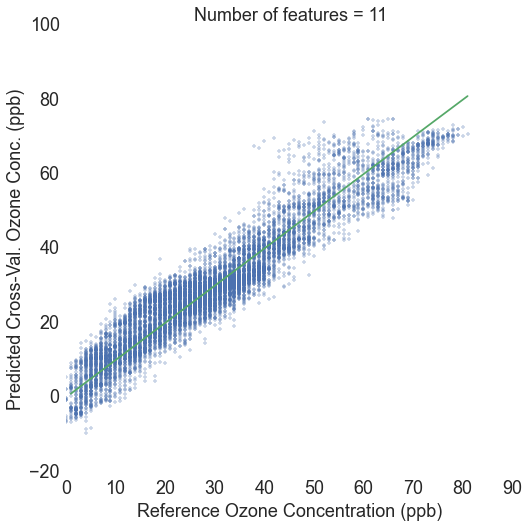

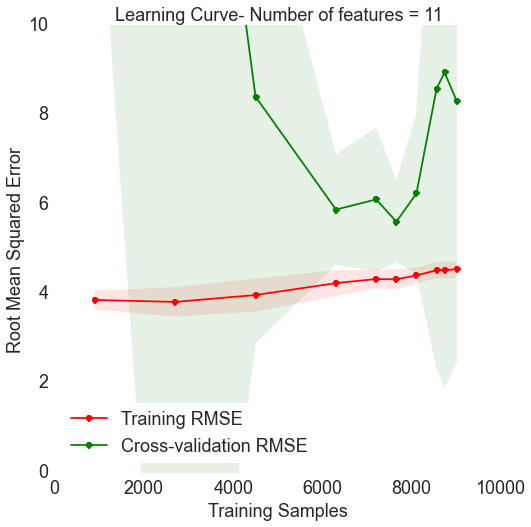

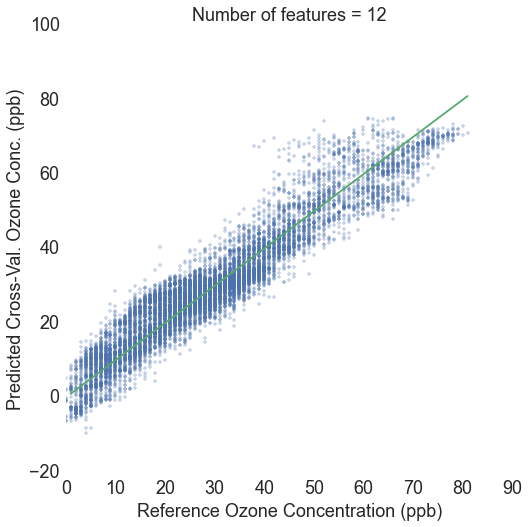

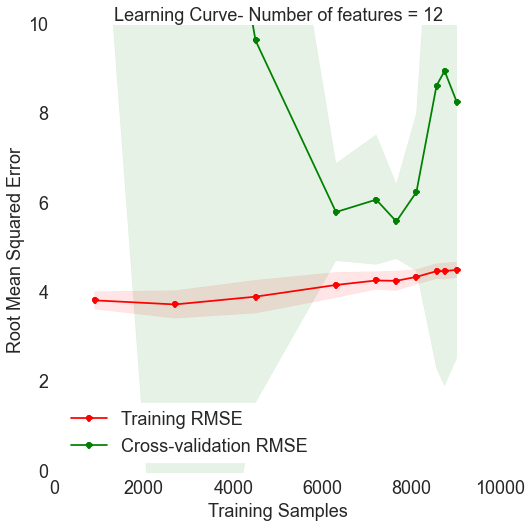

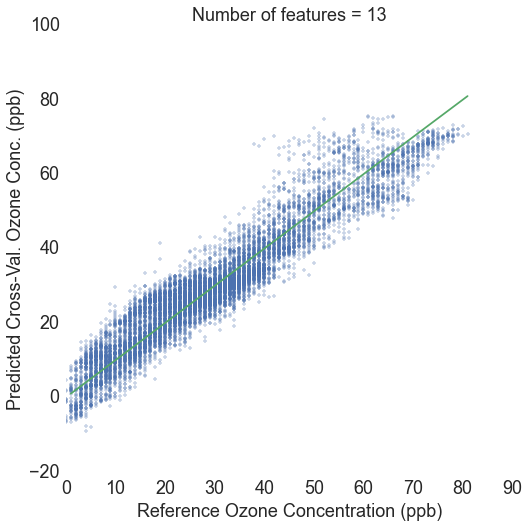

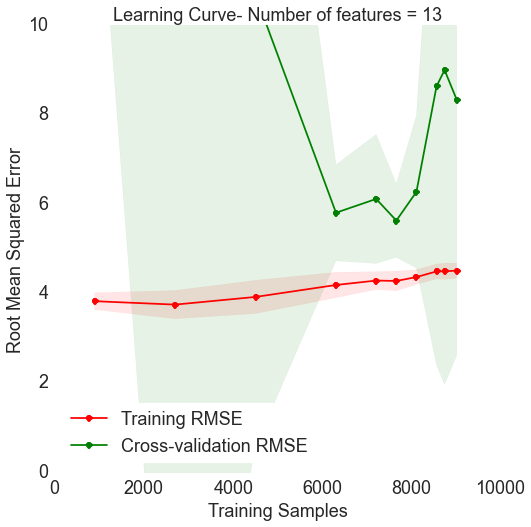

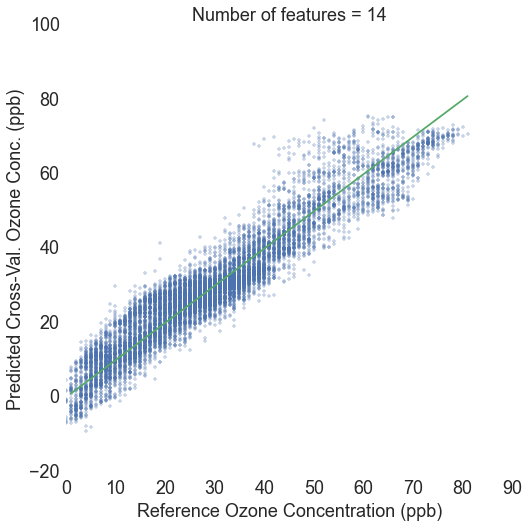

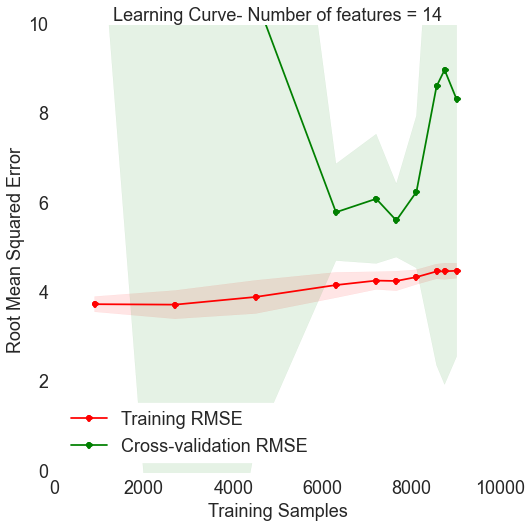

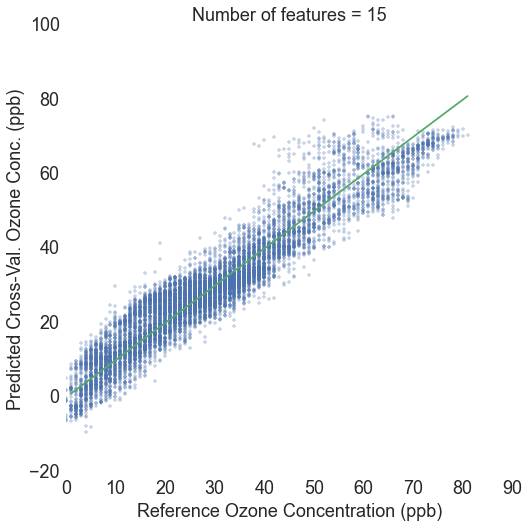

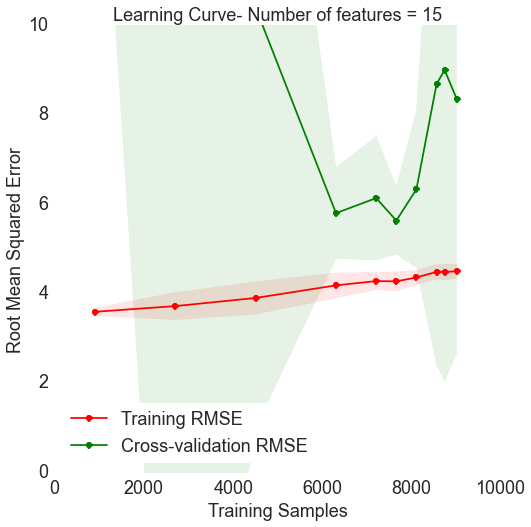

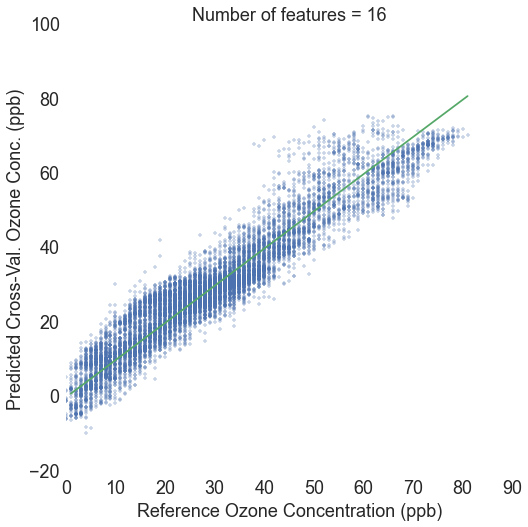

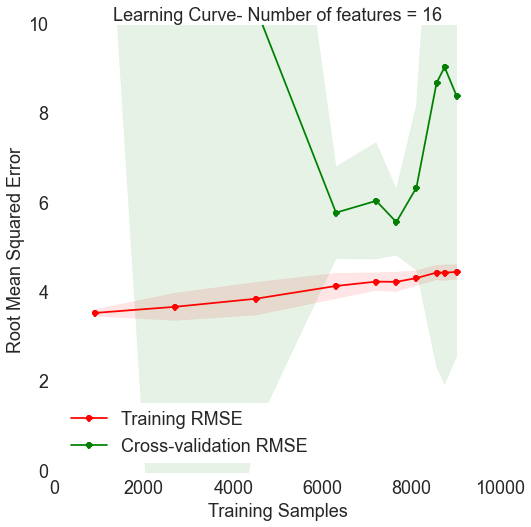

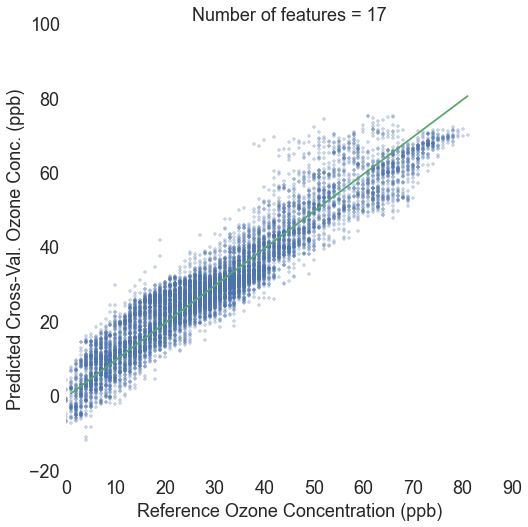

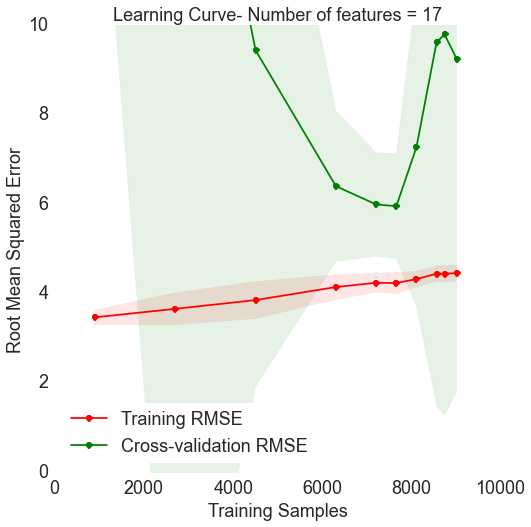

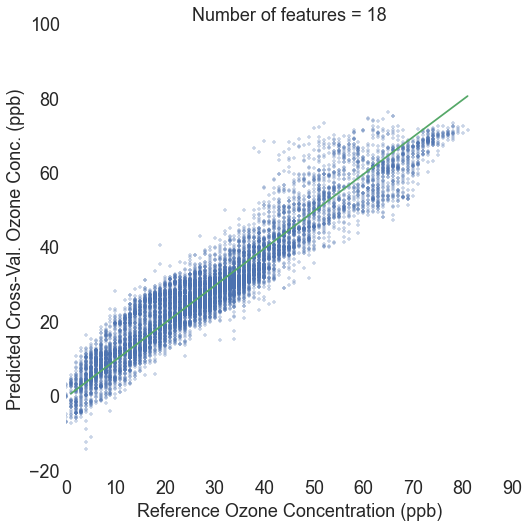

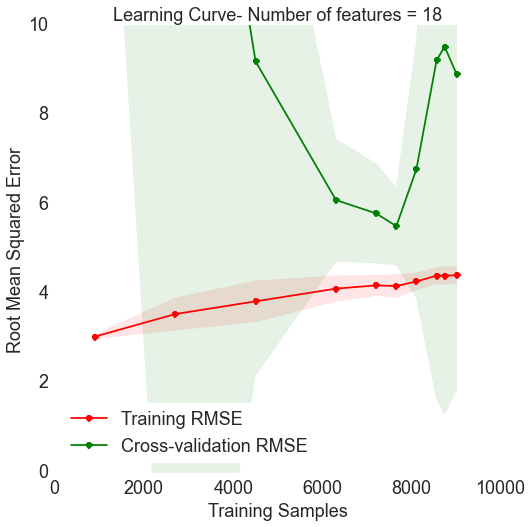

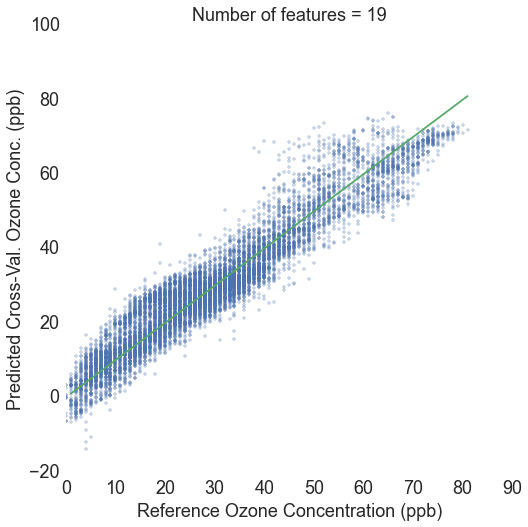

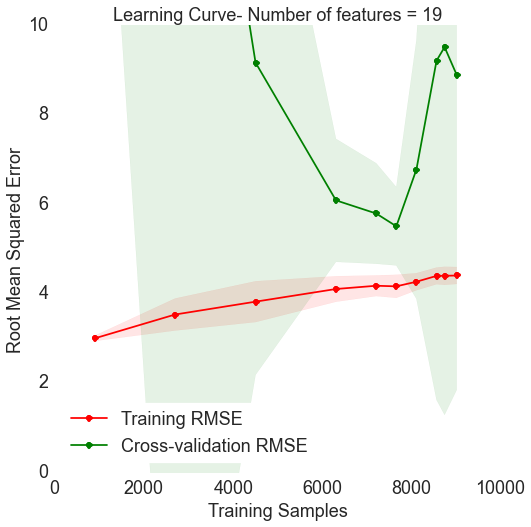

In [106]:
i = 10
while i < 20:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,10), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

###Enter the chosen number of features, and perform a linear regression.

In [232]:
num_good_feat = 15
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 4.6
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>50): -6.3
Holdout RMSE: 7.0 , High-Value Holdout RMSE: 10.0 , Holdout High Diff. in Mean.: 3.1


####Print Best Features

In [233]:
best_features

['e2v03',
 'Temp',
 'Rh',
 'days from start',
 'O3_sqrt',
 'O3_sq',
 'O3_cu',
 'ln_O3',
 'temp_sqrt',
 'temp_sq',
 'temp_cu',
 'ln_temp',
 'rh_sqrt',
 'rh_sq',
 'rh_cu']

### Plot the cross-validation data and residuals below.

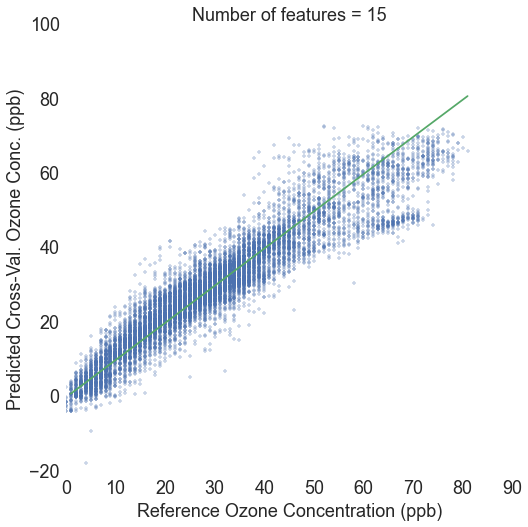

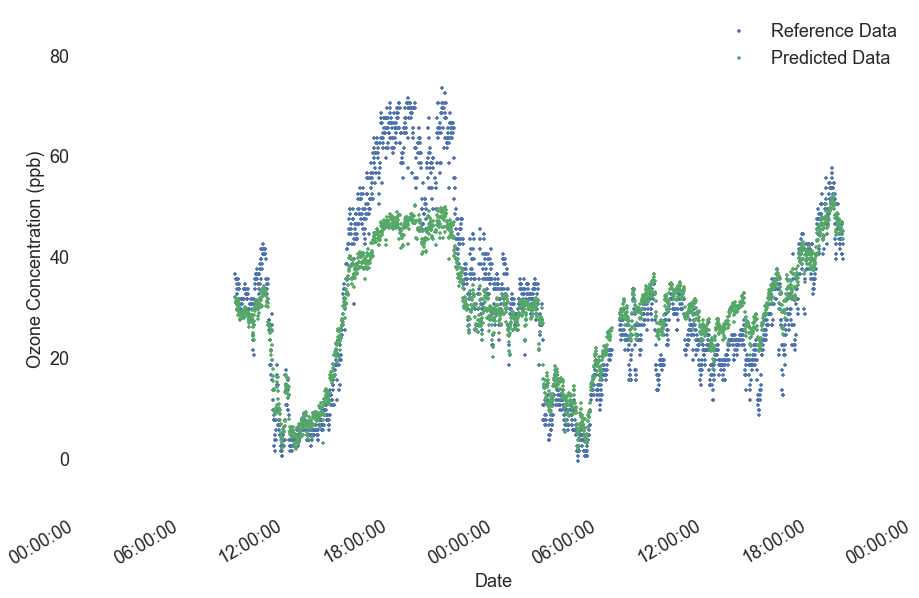

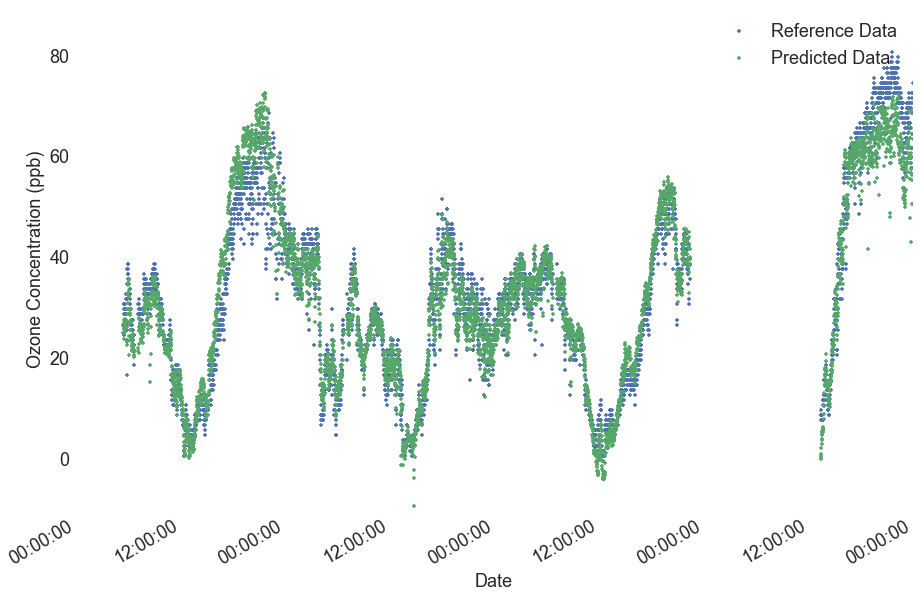

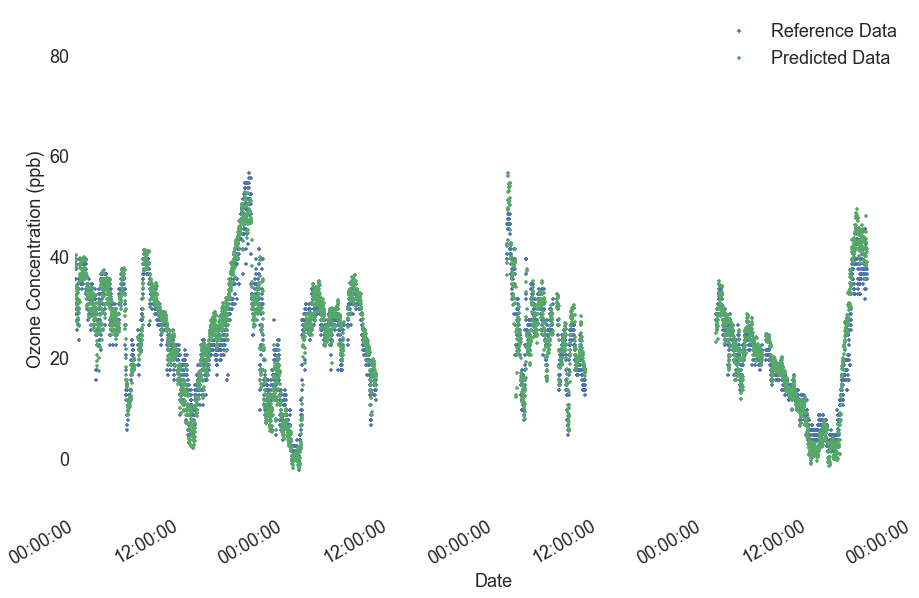

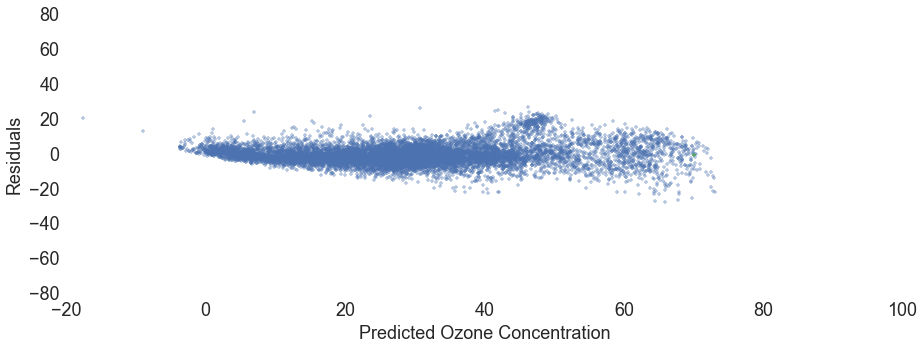

In [234]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

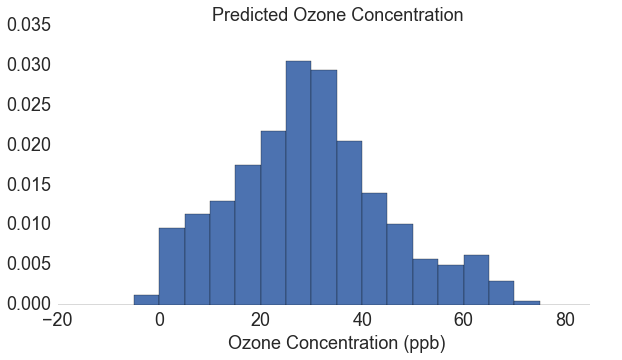

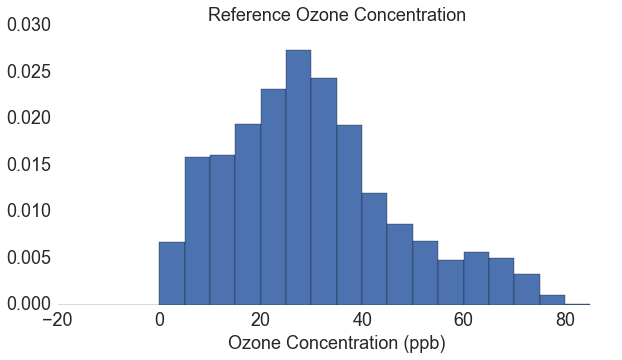

In [235]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

#Ridge Regression- All Features

In [236]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [237]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

In [238]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 9.88
lambda: 3e-07
score: 9.88
lambda: 9e-07
score: 9.87
lambda: 2.7e-06
score: 9.86
lambda: 8.1e-06
score: 9.84
lambda: 2.43e-05
score: 9.8
lambda: 7.29e-05
score: 9.72
lambda: 0.0002187
score: 9.63
lambda: 0.0006561
score: 9.55
lambda: 0.0019683
score: 9.54
lambda: 0.0059049
score: 9.54
lambda: 0.0177147
score: 9.53
lambda: 0.0531441
score: 9.52
lambda: 0.1594323
score: 9.46
lambda: 0.4782969
score: 9.61
lambda: 1.4348907
score: 10.14
lambda: 4.3046721
score: 10.7
lambda: 12.9140163
score: 10.94
lambda: 38.7420489
score: 10.91
lambda: 116.2261467
score: 10.63
lambda: 348.6784401
score: 10.46
lambda: 1046.0353203
score: 10.54
lambda: 3138.1059609
score: 10.78
lambda: 9414.3178827
score: 11.26
lambda: 28242.9536481
score: 12.39
lambda: 84728.8609443
score: 14.8
lambda: 254186.582833
score: 19.58
lambda: 762559.748499
score: 27.13
Best Lambda: 0.1594323


###Plot the values of lambda versus the coefficients and the custom score. 

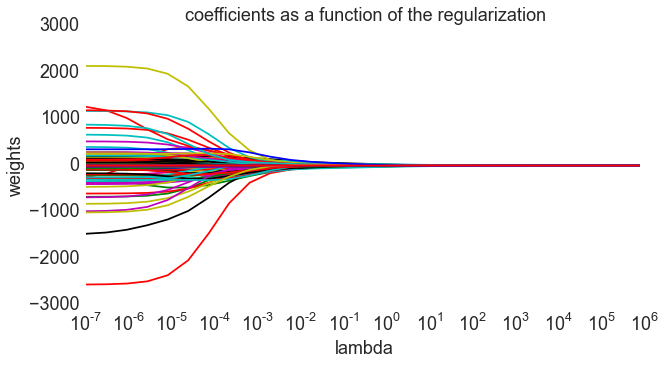

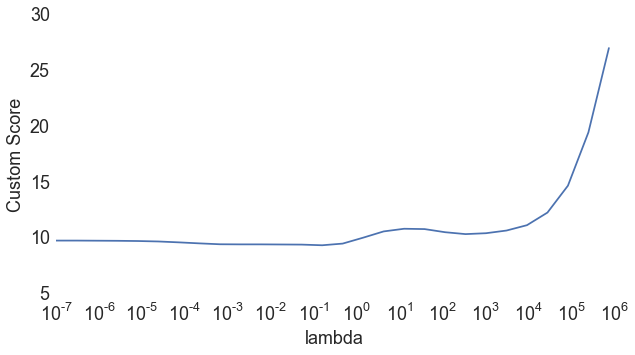

In [239]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

####Use the best lambda value found above to find errors.

In [240]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 2.6
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 10.0 , CV High Diff. in Mean (>50): -6.0
Holdout RMSE: 7.0 , High-Value Holdout RMSE: 10.0 , Holdout High Diff. in Mean.: 6.7


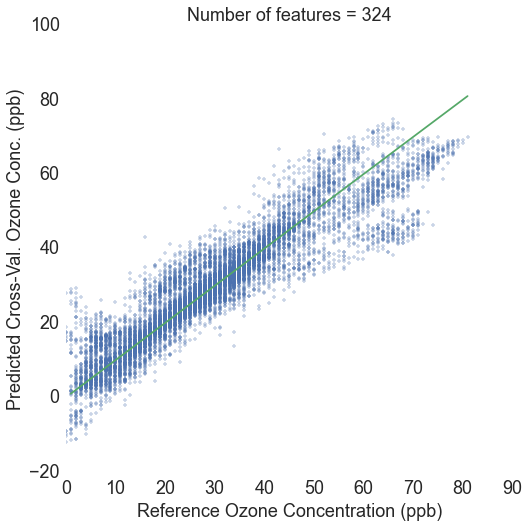

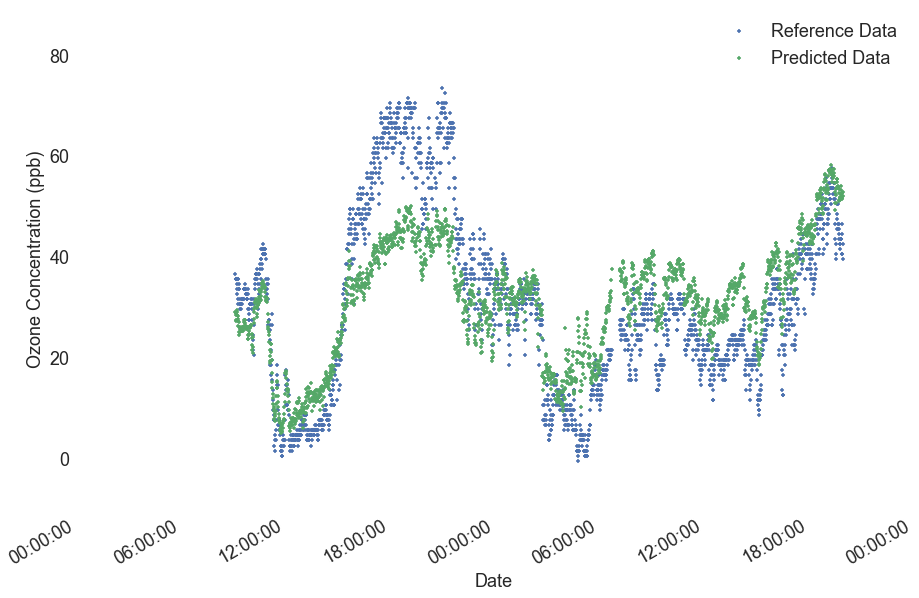

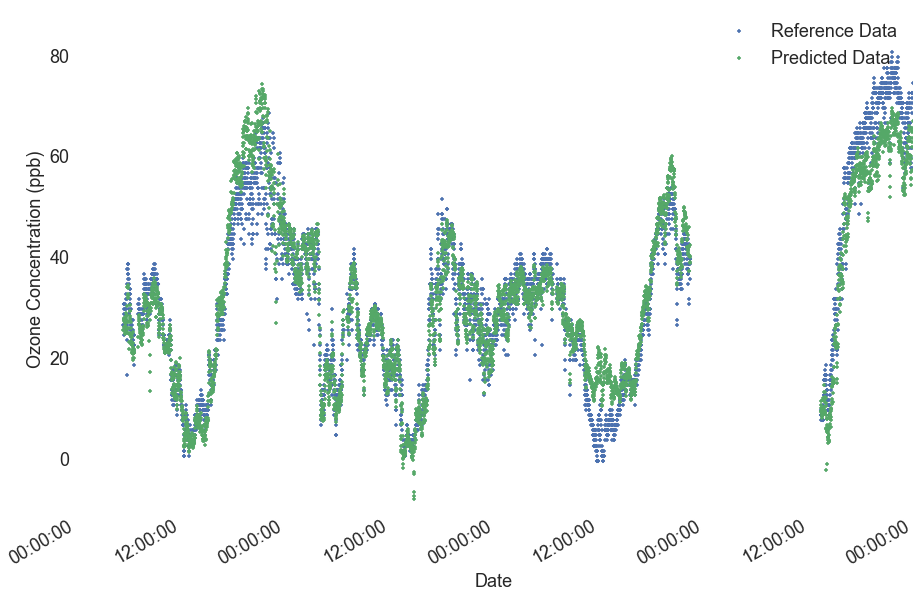

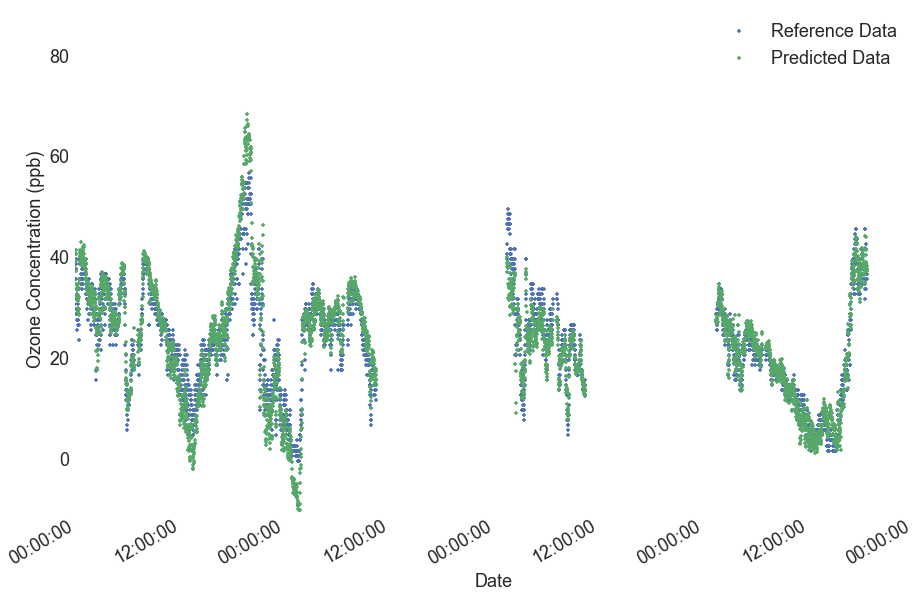

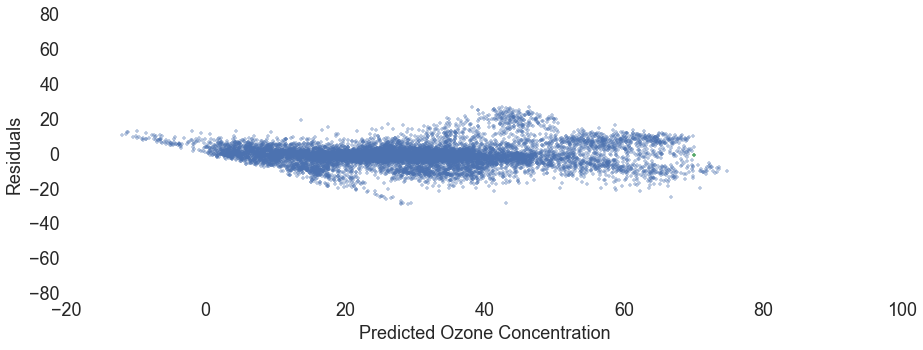

In [241]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

#Ridge Regression- Best Features

In [242]:
#define the training data
df_fits_best = df_tr[best_features + [ref_column] + ['day']].dropna()
X = df_scaled[best_features].values
y = df_scaled[ref_column].values

In [243]:
best_lambda_ridge_best, lambda_ridge_best, coefs_best, mean_score_lambda_best = find_best_lambda(Ridge, best_features, df_fits_best, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 9.99
lambda: 3e-07
score: 9.98
lambda: 9e-07
score: 9.97
lambda: 2.7e-06
score: 9.97
lambda: 8.1e-06
score: 9.98
lambda: 2.43e-05
score: 10.0
lambda: 7.29e-05
score: 10.02
lambda: 0.0002187
score: 10.04
lambda: 0.0006561
score: 10.09
lambda: 0.0019683
score: 10.17
lambda: 0.0059049
score: 10.21
lambda: 0.0177147
score: 10.16
lambda: 0.0531441
score: 10.03
lambda: 0.1594323
score: 10.01
lambda: 0.4782969
score: 10.16
lambda: 1.4348907
score: 10.36
lambda: 4.3046721
score: 10.4
lambda: 12.9140163
score: 10.36
lambda: 38.7420489
score: 10.51
lambda: 116.2261467
score: 10.84
lambda: 348.6784401
score: 11.13
lambda: 1046.0353203
score: 11.65
lambda: 3138.1059609
score: 13.07
lambda: 9414.3178827
score: 15.96
lambda: 28242.9536481
score: 21.16
lambda: 84728.8609443
score: 28.98
lambda: 254186.582833
score: 36.69
lambda: 762559.748499
score: 41.35
Best Lambda: 9e-07


###Plot the values of lambda versus the coefficients and the custom score. 


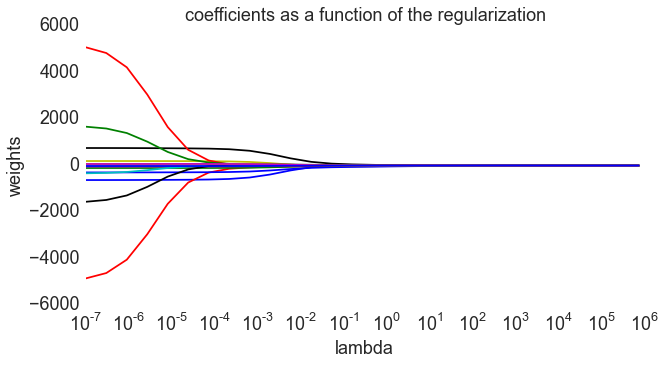

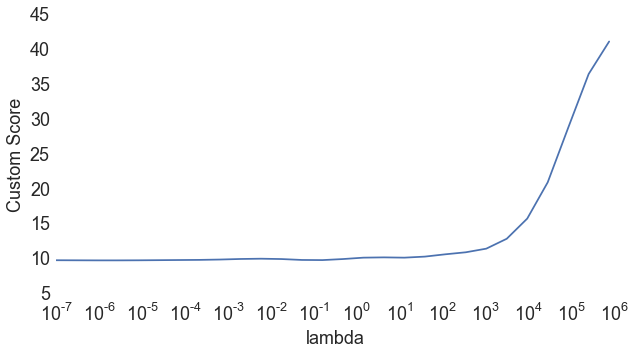

In [244]:
plot_lambda(lambda_ridge_best, coefs_best, mean_score_lambda_best)

####Use the best lambda value found above to find errors.

In [245]:
MSE_CV_ridge_best, MSE_T_ridge_best, MSE_H_ridge_best, high_MSE_cv_ridge_best, X_pred_cv_ridge_best, y_cv_ridge_best, df_cv_ridge_best, df_H_ridge_best = cross_validation_by_day(Ridge(alpha = best_lambda_ridge_best), best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 4.6
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>50): -6.2
Holdout RMSE: 7.0 , High-Value Holdout RMSE: 10.0 , Holdout High Diff. in Mean.: 3.1


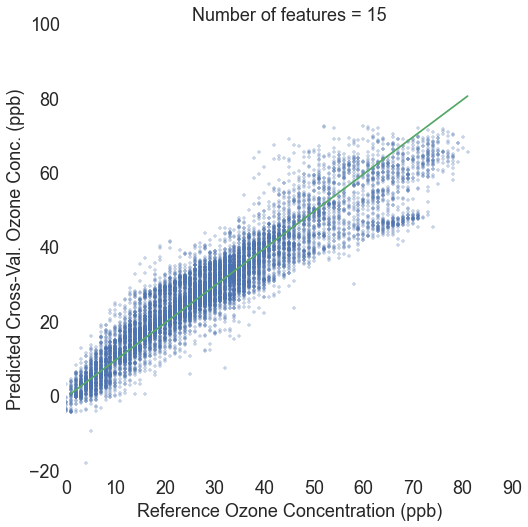

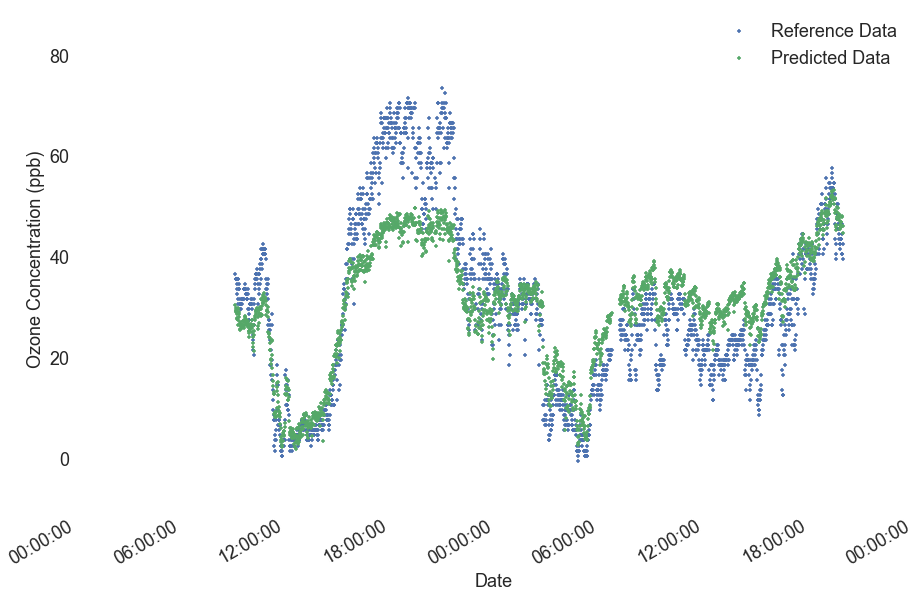

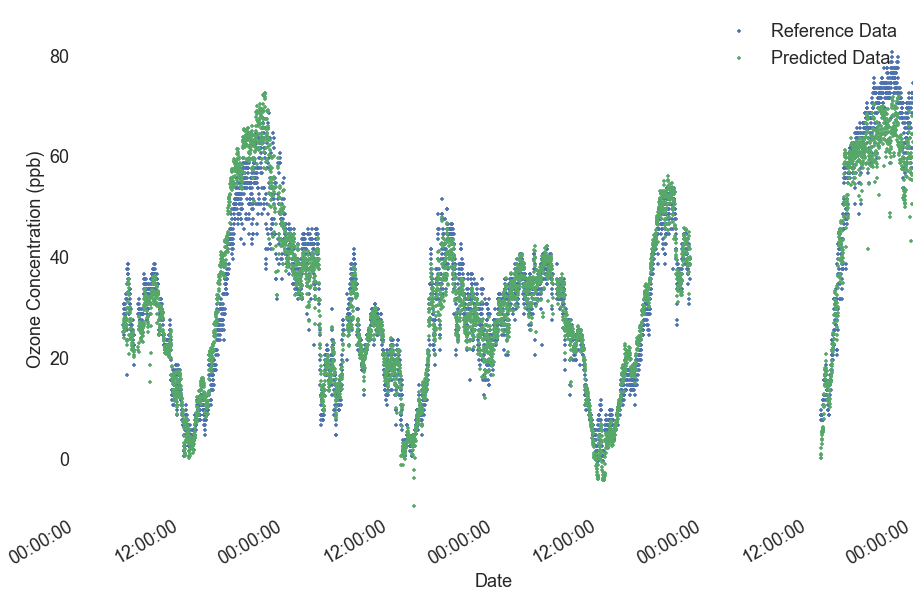

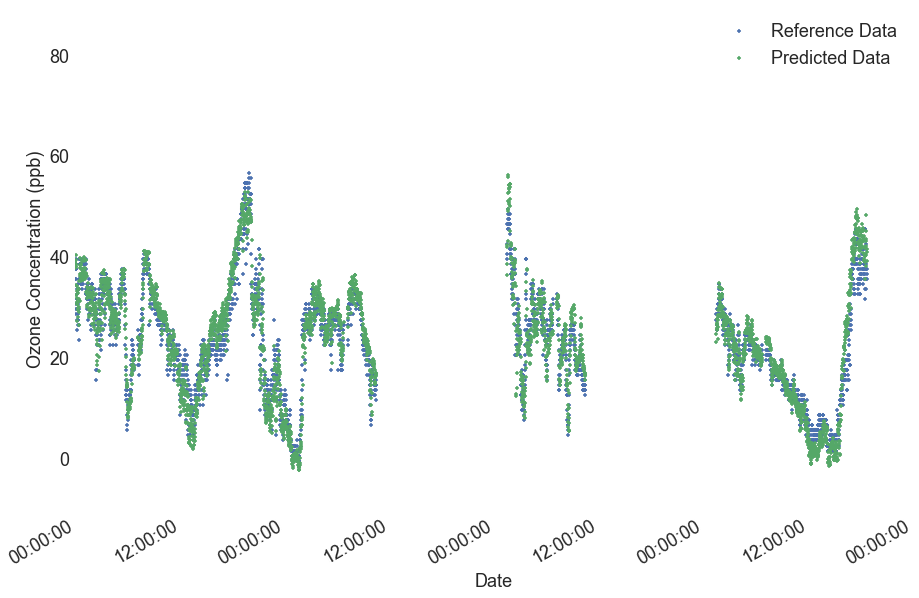

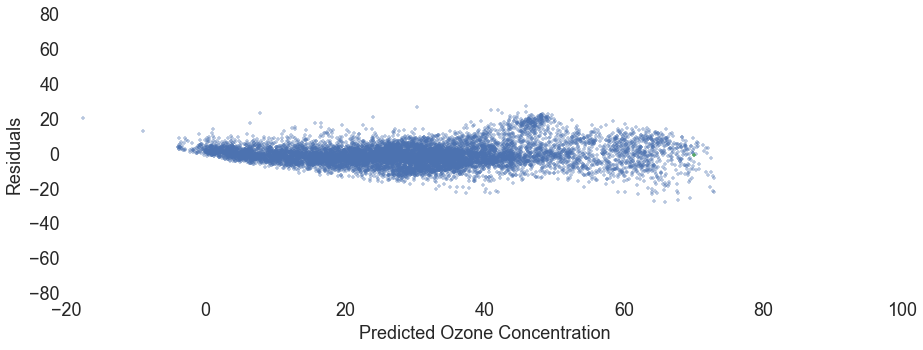

In [246]:
fitted_vs_ref_plot(df_cv_ridge_best, len(best_features), ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge_best, pod_number, 3, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge_best, ref_column)

#Lasso- All Features

In [247]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 11.22
lambda: 3e-06
score: 11.22
lambda: 9e-06
score: 11.22
lambda: 2.7e-05
score: 11.21
lambda: 8.1e-05
score: 11.2
lambda: 0.000243
score: 11.16
lambda: 0.000729
score: 11.0
lambda: 0.002187
score: 10.66
lambda: 0.006561
score: 9.78
lambda: 0.019683
score: 8.69
lambda: 0.059049
score: 8.96
lambda: 0.177147
score: 9.13
lambda: 0.531441
score: 10.26
lambda: 1.594323
score: 13.55
lambda: 4.782969
score: 22.53
lambda: 14.348907
score: 43.86
lambda: 43.046721
score: 44.48
Best Lambda: 0.019683


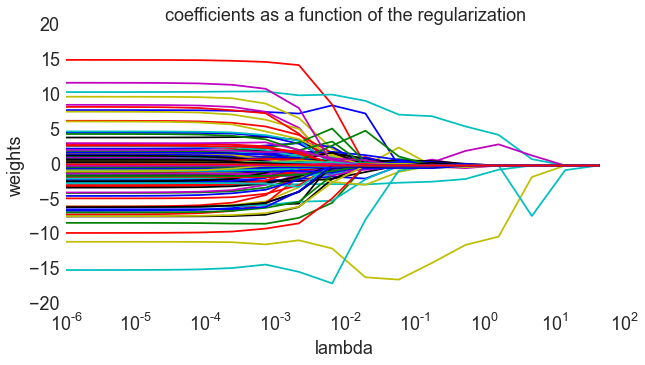

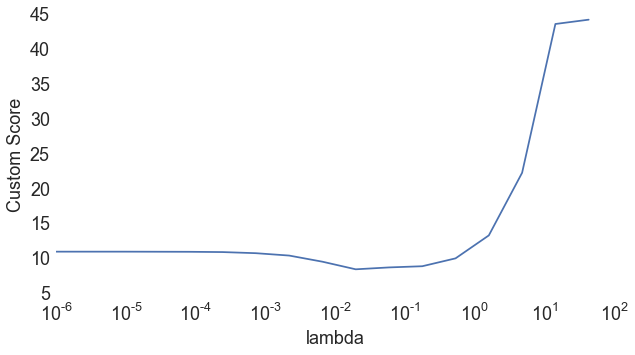

In [248]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

####Use the best lambda value found above to find holdout values.

In [249]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 3.3
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>50): -6.5
Holdout RMSE: 4.0 , High-Value Holdout RMSE: 4.0 , Holdout High Diff. in Mean.: -3.3


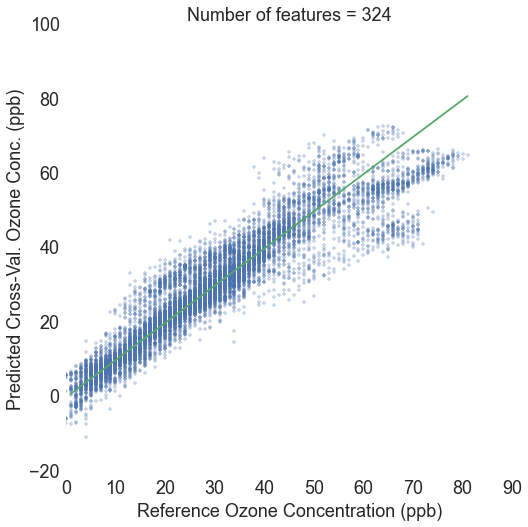

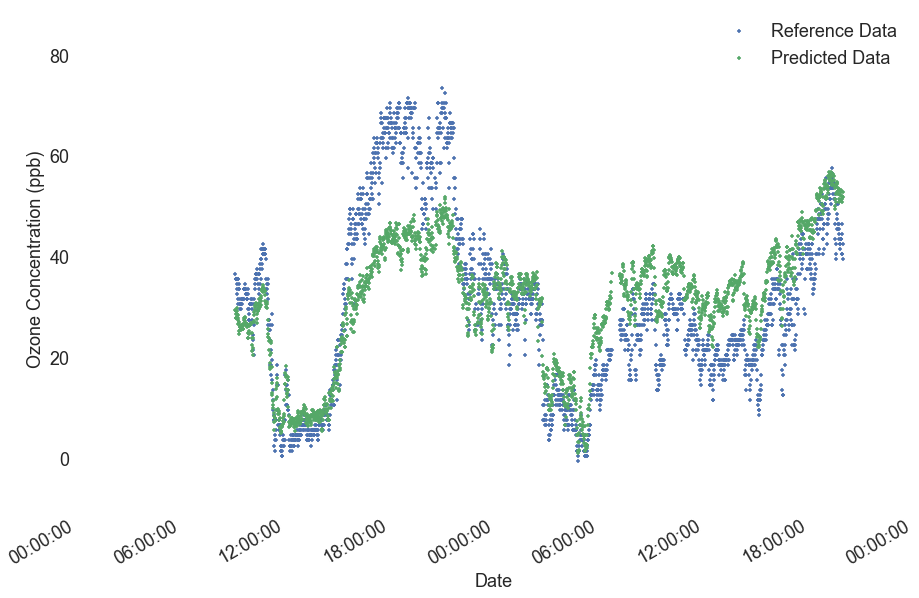

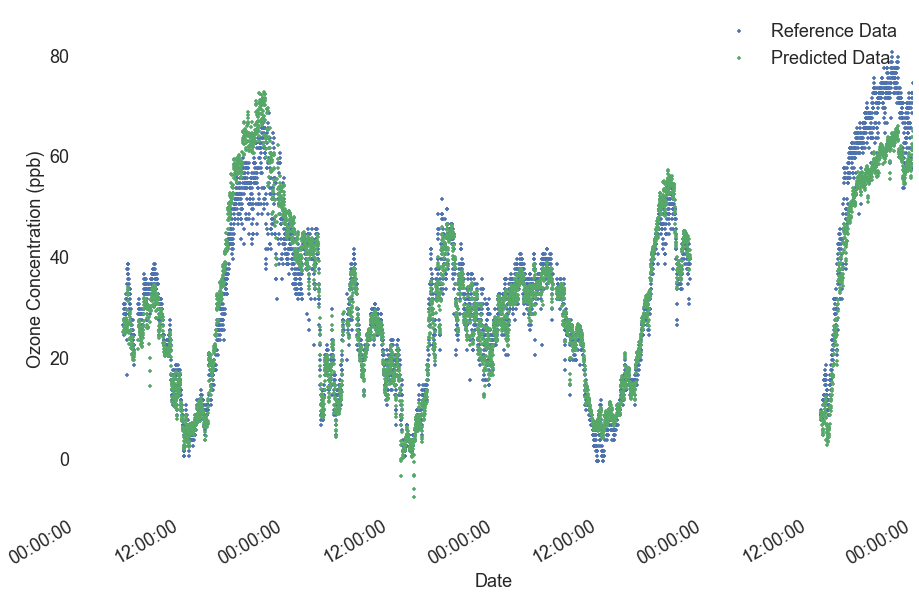

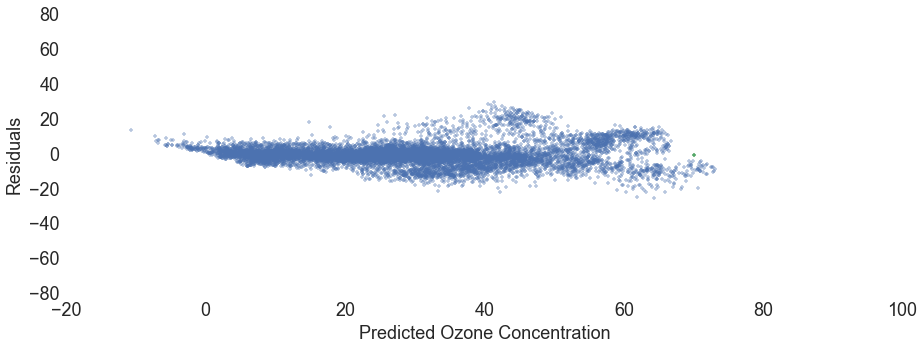

In [250]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

#Lasso- Best Features

In [251]:
best_lambda_lasso_best, lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best = find_best_lambda(Lasso, best_features, df_fits_best, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000000000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-13
score: 10.49
lambda: 3e-13
score: 10.49
lambda: 9e-13
score: 10.49
lambda: 2.7e-12
score: 10.49
lambda: 8.1e-12
score: 10.49
lambda: 2.43e-11
score: 10.49
lambda: 7.29e-11
score: 10.49
lambda: 2.187e-10
score: 10.49
lambda: 6.561e-10
score: 10.49
lambda: 1.9683e-09
score: 10.49
lambda: 5.9049e-09
score: 10.49
lambda: 1.77147e-08
score: 10.49
lambda: 5.31441e-08
score: 10.49
lambda: 1.594323e-07
score: 10.49
lambda: 4.782969e-07
score: 10.49
lambda: 1.4348907e-06
score: 10.49
lambda: 4.3046721e-06
score: 10.49
lambda: 1.29140163e-05
score: 10.49
lambda: 3.87420489e-05
score: 10.49
lambda: 0.0001162261467
score: 10.49
lambda: 0.0003486784401
score: 10.48
lambda: 0.0010460353203
score: 10.44
lambda: 0.0031381059609
score: 10.33
lambda: 0.0094143178827
score: 9.87
lambda: 0.0282429536481
score: 10.17
lambda: 0.0847288609443
score: 10.56
lambda: 0.254186582833
score: 11.04
lambda: 0.762559748499
score: 12.59
lambda: 2.2876792455
score: 16.87
lambda: 6.86303773649
score: 29.62


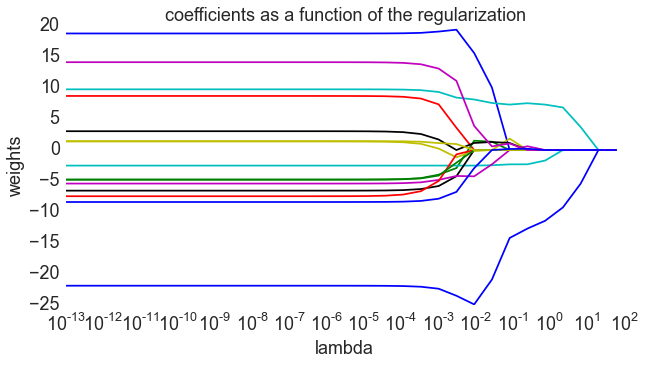

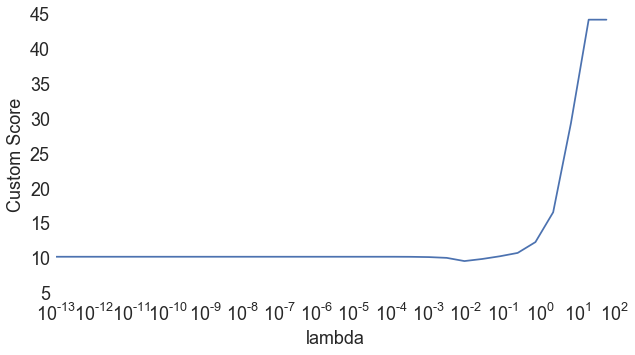

In [252]:
plot_lambda(lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best)

In [253]:
MSE_CV_lasso_best, MSE_T_lasso_best, MSE_H_lasso_best, high_MSE_cv_lasso_best, X_pred_cv_lasso_best, y_cv_lasso, df_cv_lasso_best, df_H_lasso_best = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 4.8
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 8.0 , CV High Diff. in Mean (>50): -6.0
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 6.0 , Holdout High Diff. in Mean.: -3.9


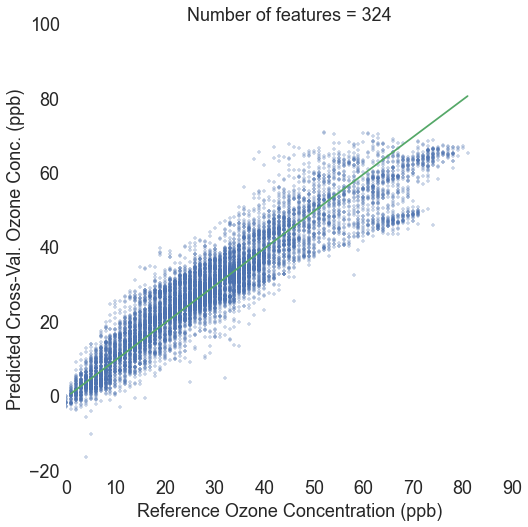

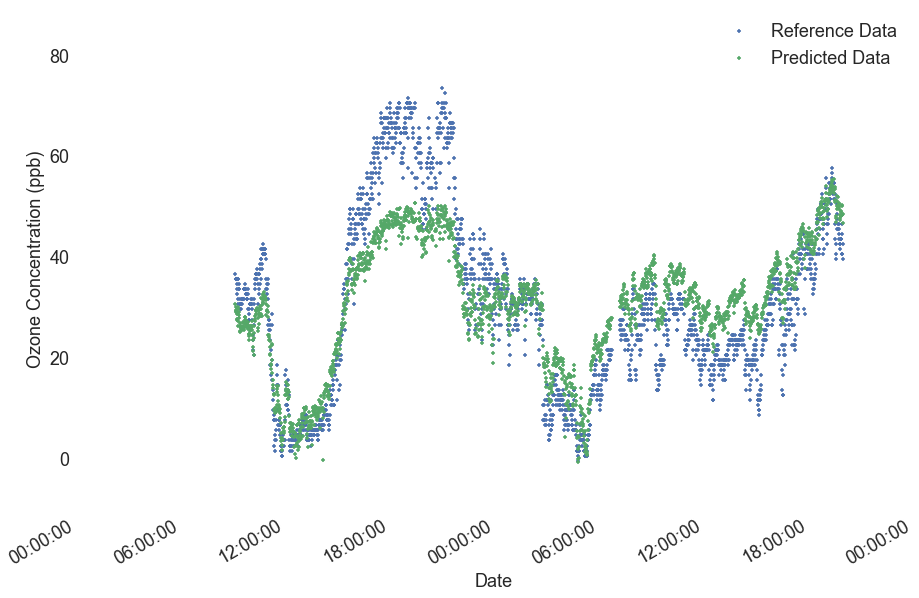

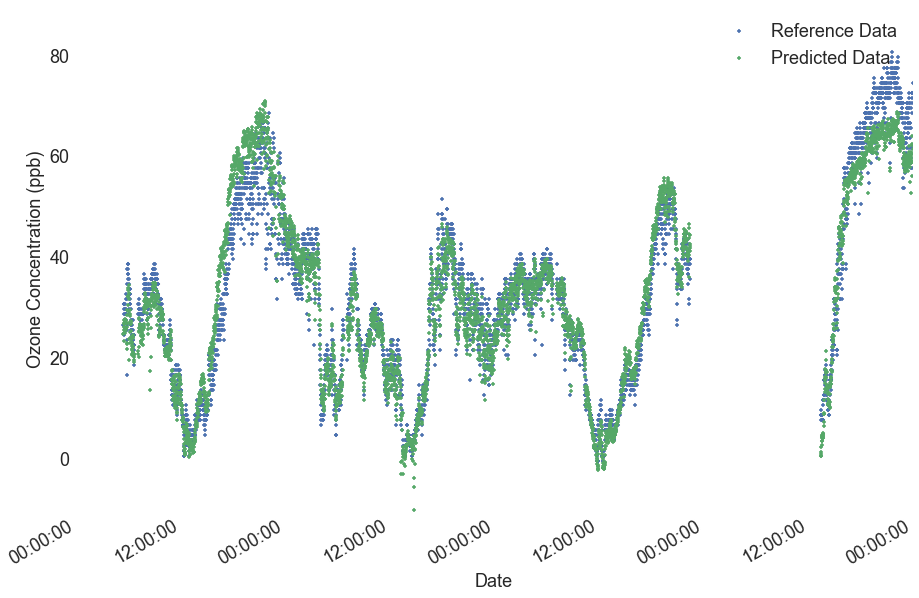

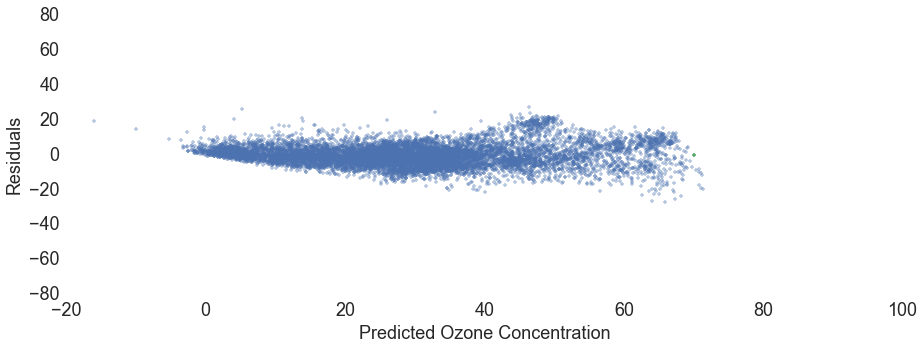

In [254]:
fitted_vs_ref_plot(df_cv_lasso_best, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso_best, ref_column)

#Support Vector Machine

In [255]:
RMSE_CV_day, df_svm_fit = fit_svm_and_find_MSE(best_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

7-11
7-12
8-21
8-22
8-23
8-24
8-25
8-26
8-27
8-28
8-29
<bound method GridSearchCV.get_params of GridSearchCV(cv=None,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1e-06, 1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(custom_SVM_scoring_function, greater_is_better=False),
       verbose=0)>
Training RMSE: 2.2
Cross-Validation RMSE: 2.0 , High-Value CV RMSE: 3.0 , CV High Diff. in Mean (>50): -3.6
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 6.0 , Holdout High Diff. in Mean.: -3.3


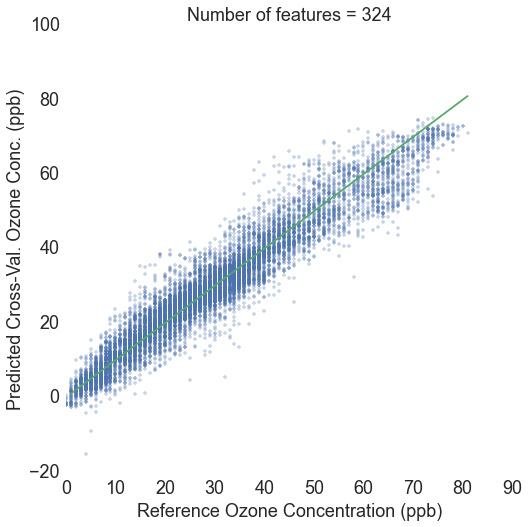

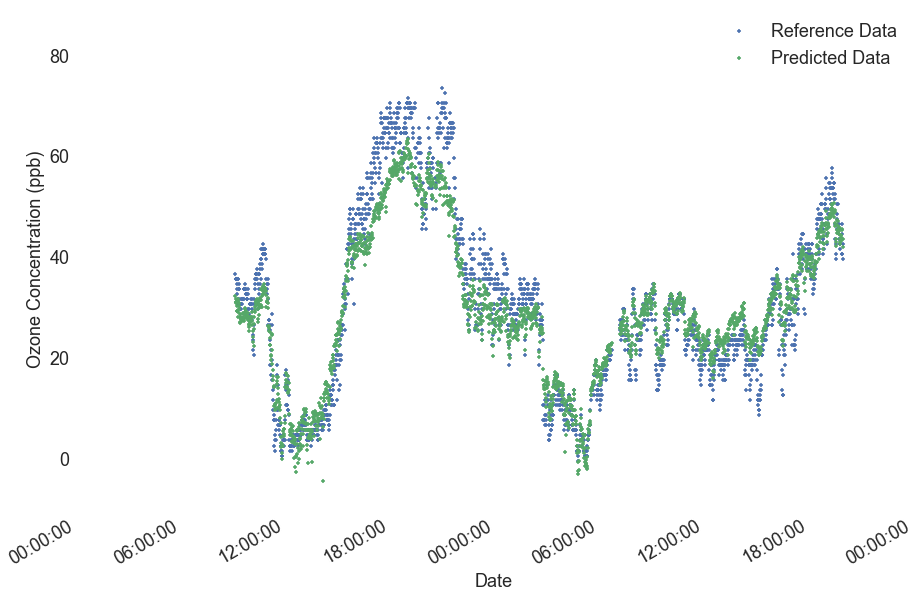

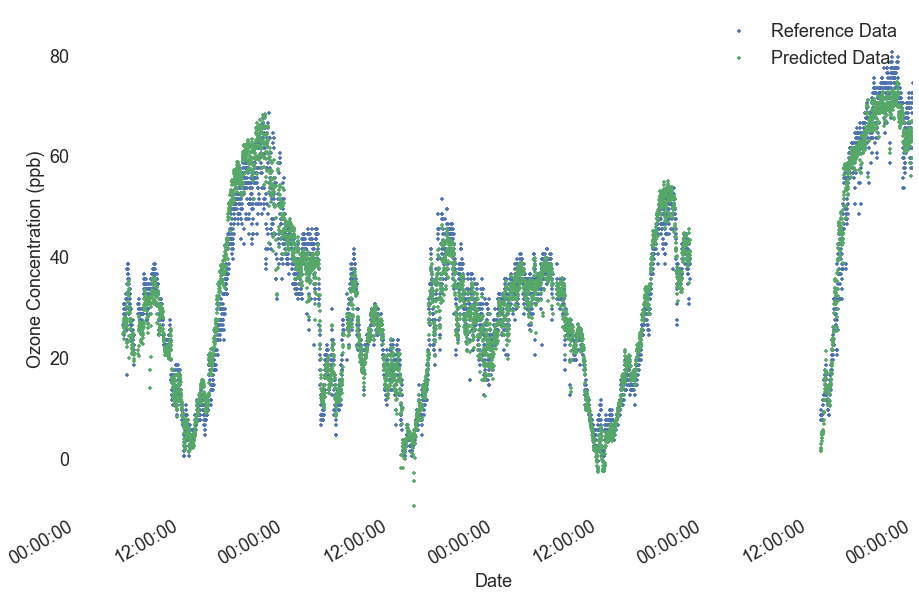

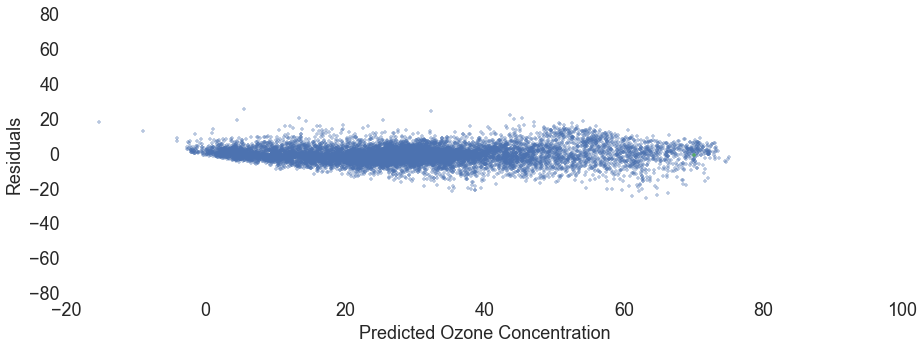

In [256]:
fitted_vs_ref_plot(df_svm_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_svm_fit, ref_column)

###### 